In [7]:
import sys, os, time, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
home_path = os.path.abspath(os.getcwd()+"/..")
sys.path.append(home_path)
sys.path.append(os.getcwd()+"/.."+"/.."+"/.."+"/JamesAHardwick")
from functions import *
from plotting_functions import *
from GF_functions import *
from PM_functions import *
from AHC_functions import *

In [8]:
# ---> physics params <---
c0 = 343.  # [m/s]
v = 40000  # [Hz]
lam = c0 / v  # [m]
k = 2 * np.pi / lam  # [rads/m]
resolution = 4

In [9]:
# ----> AMM plane <----
m_AMM, n_AMM = 16, 16
dx_AMM = lam/2 # cell spacing [m]
AMM_centrepoint = (0, 0, 0)
AMM_sidelengths = [((m_AMM/2)*dx_AMM, (m_AMM/2)*dx_AMM),
                   ((n_AMM/2)*dx_AMM, (n_AMM/2)*dx_AMM),
                   (0, 0)]
AMM_points = points_vector_builder(AMM_centrepoint, AMM_sidelengths, dx_AMM)

# ----> normals & areas <----
normals = [np.zeros((1, n_AMM*m_AMM)), np.zeros((1, n_AMM*m_AMM)), np.ones((1, n_AMM*m_AMM))]
areas = (dx_AMM**2)*np.ones((1, n_AMM*m_AMM))

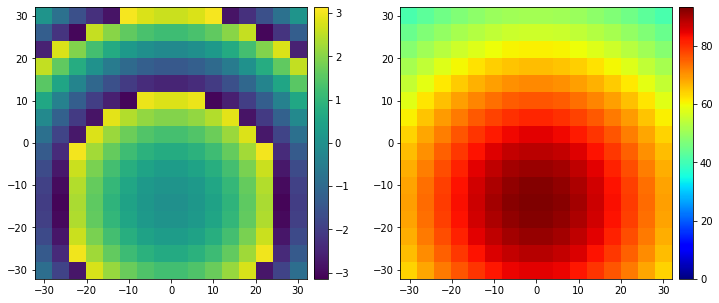

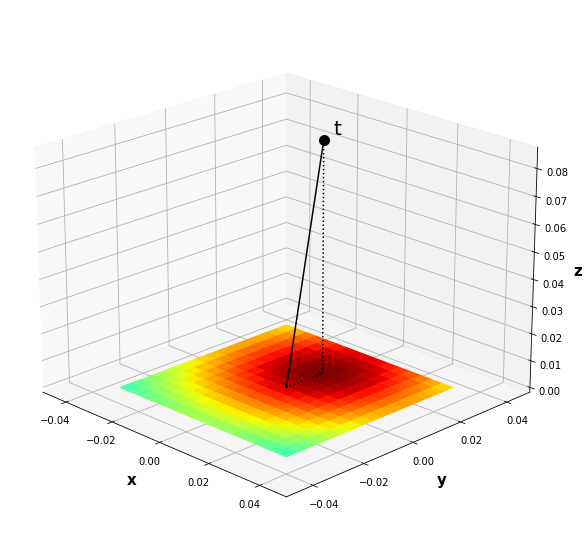

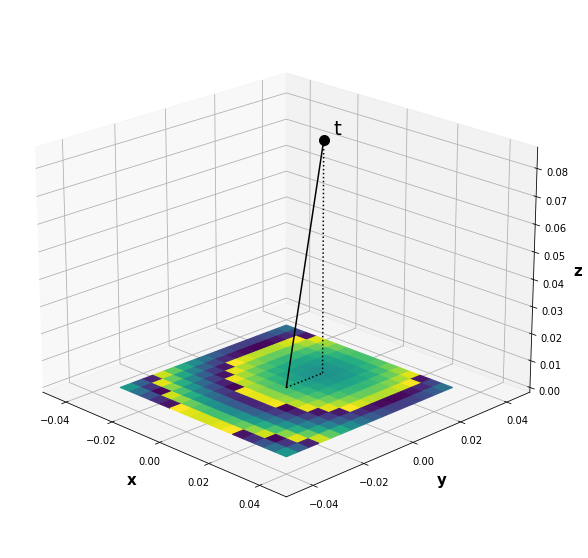

In [21]:
# ----> Piston model for transducer source <----

# ----> transducer params <----
dx_tran =  10.5/1000 # diameter of a transducer [m] (actually, they are 10mm in diameter, with a spacing of 0.5mm)
p0 = 8.02 # tranducer reference pressure [Pa] 
A_magnitude = 1 # amplitude for each transducer to take (max=1, min=0)
tran_prop_dist = 10*lam # [m]
tran_angle = 10 # [degrees]
tran_m, tran_n = 1, 1

# ----> x,y,z <----
tx = np.arange((dx_tran/2)*(1-tran_m), (dx_tran/2)*(1+tran_m), dx_tran)
ty = np.arange((dx_tran/2)*(1-tran_n), (dx_tran/2)*(1+tran_n), dx_tran)
tz = np.zeros(len(tx))

# ----> rotation and translation <----
rot_dir = "y"
tx_rot, ty_rot, tz_rot = transducer_rotate_and_translate(tx, ty, tz, rot_dir, tran_prop_dist, tran_angle)

# ----> piston model <----

rxyz, rxy = pesb(m_AMM*dx_AMM, n_AMM*dx_AMM, dx_AMM, tran_angle, tx_rot, ty_rot, tz_rot)
H = piston_model_matrix(rxy, rxyz, k, p0, dx_tran) # propagator
Pt = A_magnitude*np.ones((tran_m*tran_n))*np.exp(1j*np.zeros((tran_m*tran_n))) # transducer complex pressure
Pf = np.dot(H, Pt).reshape((m_AMM, n_AMM)) # propagate to far field and reshape to array

# ----> 2D Plotting <----
fig, ax = basic_plotter(nrows=1, ncols=2,
                        figsize = (12, 5),
                        plottable_list = [np.angle(Pf), abs(Pf)],
                        cmap_list = [plt.get_cmap("viridis"), plt.get_cmap("jet")],
                        vmax_list = [np.pi, np.amax(abs(Pf))], vmin_list = [-np.pi, 0],
                        points_list = [AMM_points, AMM_points])
plt.show()

# ----> 3D Plotting <----
fig = plt.figure(figsize=(12, 10))
rgba_vec = plt.cm.get_cmap('jet')(abs(Pf).flatten()/np.amax(abs(Pf).flatten()))

ax = transducer_position_plotter(ax, tx_rot, ty_rot, tz_rot, rot_dir,
                                 AMM_points, rgba_vec, dx_AMM, dx_tran, 15)
plt.show()

fig = plt.figure(figsize=(12, 10))
rgba_vec = plt.cm.get_cmap('viridis')((np.angle(Pf)+np.pi).flatten()/np.amax((np.angle(Pf)+np.pi).flatten()))

ax = transducer_position_plotter(ax, tx_rot, ty_rot, tz_rot, rot_dir,
                                 AMM_points, rgba_vec, dx_AMM, dx_tran, 15)
plt.show()

In [22]:
focus_coords_list = [(0,  lam,  6*lam)]

# ----> xz eval plane <----
m_xz_eval, n_xz_eval = m_AMM*resolution, n_AMM*resolution
dx_xz_eval = dx_AMM/resolution
xz_eval_centrepoint = (0, 0, 10*lam)
xz_eval_sidelengths = [(5*lam, 5*lam), (0, 0), (10*lam, 7.5*lam)] # [(-x, +x), (-y, +y), (-z, +z)]

xz_eval_points = points_vector_builder(xz_eval_centrepoint, xz_eval_sidelengths, dx_xz_eval)

# ----> xy eval planes <----
m_xy_eval, n_xy_eval = m_AMM*resolution, n_AMM*resolution
dx_xy_eval = dx_AMM/resolution
xy_eval_sidelengths = [(5*lam, 5*lam), (5*lam, 5*lam), (0, 0)] # [(-x, +x), (-y, +y), (-z, +z)]

xy_eval_points_list = []
for focus_coords in focus_coords_list:
    xy_eval_centrepoint = (focus_coords[1], focus_coords[0], focus_coords[2]) # why are x and y swapped here?
    xy_eval_points_list.append(points_vector_builder(xy_eval_centrepoint, xy_eval_sidelengths, dx_xy_eval))

 ID = 0


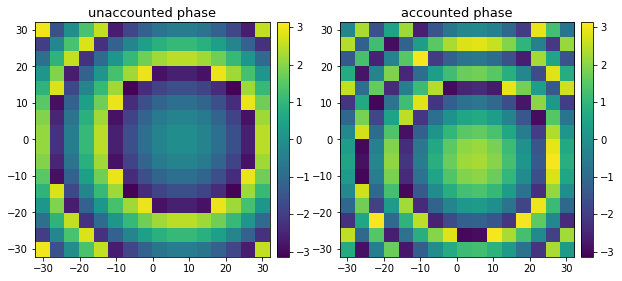

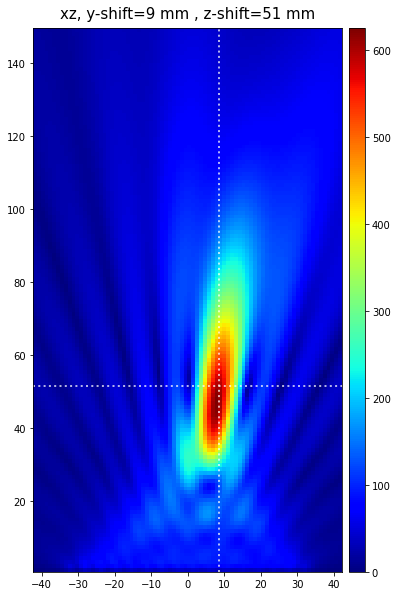

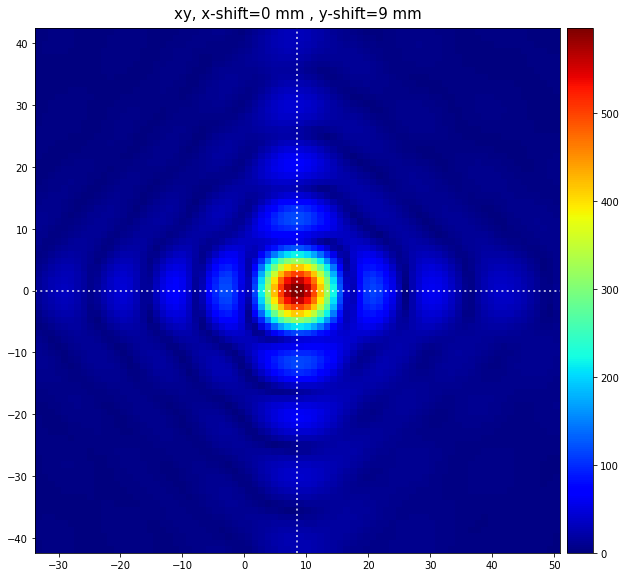

In [23]:
unaccounted_phasemaps, accounted_phasemaps, xz_propagations, xy_propagations = [], [], [], []

for i, focus_coords in enumerate(focus_coords_list):
    
    # ---> input phase assuming plane wave <---
    phasemap_vec = focus_phasemap_builder(AMM_points, focus_coords, k)
    phasemap_vec = np.mod(phasemap_vec, 2*np.pi) - np.pi
    phasemap_mat = np.fliplr(phasemap_vec.reshape(m_AMM, n_AMM).T)
    unaccounted_phasemaps.append(phasemap_mat)
    
    # ---> input phase assuming transducer <---
    accounted_phasemap_mat = np.mod(phasemap_mat - np.angle(Pf), 2*np.pi) - np.pi
    accounted_phasemaps.append(accounted_phasemap_mat)
    
    # ---> total complex pressure at AMM surface <---
    surface_pressure = abs(Pf)*np.exp(1j*(accounted_phasemap_mat + np.angle(Pf)))
    
    print(" ID =", i)
    
    # ----> plotting xz abs(pressure) <----
    fig, ax = basic_plotter(nrows=1, ncols=2,
                            figsize = (10, 5),
                            plottable_list = [phasemap_mat, accounted_phasemap_mat],
                            cmap_list = [plt.get_cmap("viridis"), plt.get_cmap("viridis")],
                            vmax_list = [np.pi, np.pi],
                            vmin_list = [-np.pi, -np.pi],
                            points_list = [AMM_points, AMM_points])
    
    ax.flat[0].set_title("unaccounted phase", fontsize=13, pad=5)
    ax.flat[1].set_title("accounted phase", fontsize=13, pad=5)
    
    plt.show()
    
    # ----> xz pressure <----
    
    xz_H = GF_propagator_function_builder(AMM_points, xz_eval_points, normals, areas, k)
    xz_propagation = GF_prop(surface_pressure.flatten(), xz_H, "forward") \
                             .reshape(pf_shape(xz_eval_sidelengths, resolution, lam))
    xz_propagation = np.flipud(xz_propagation)
    xz_propagations.append(xz_propagation)
    
    fig, ax = basic_plotter(nrows=1, ncols=1,
                            figsize = (10, 10),
                            plottable_list = [abs(xz_propagation)],
                            cmap_list = [plt.get_cmap("jet")],
                            vmax_list = [np.amax(abs(xz_propagations[0]))],
                            vmin_list = [0],
                            points_list = [xz_eval_points])
    
    ax.set_title("xz, y-shift="+str(round(1000*focus_coords[1]))+" mm ,"+ \
                " z-shift="+str(round(1000*focus_coords[2]))+" mm",
                 fontsize=15, pad=10)
    
    ax.axhline(1000*focus_coords[2], c="w", ls=":", lw=2, alpha=.7)
    ax.axvline(1000*focus_coords[1], c="w", ls=":", lw=2, alpha=.7)
    
    plt.show()

    # ----> xy pressure <----
    
    xy_H = GF_propagator_function_builder(AMM_points, xy_eval_points_list[i], normals, areas, k)
    xy_propagation = GF_prop(surface_pressure.flatten(), xy_H, "forward") \
                             .reshape(pf_shape(xy_eval_sidelengths,resolution, lam))
    xy_propagation = np.flipud(xy_propagation)
    xy_propagations.append(xy_propagation)

    fig, ax = basic_plotter(nrows=1, ncols=1,
                            figsize = (10, 10),
                            plottable_list = [abs(xy_propagation)],
                            cmap_list = [plt.get_cmap("jet")],
                            vmax_list = [np.amax(abs(xy_propagations[0]))],
                            vmin_list = [0],
                            points_list = [xy_eval_points_list[i]])

    ax.set_title("xy, x-shift="+str(round(1000*focus_coords[0]))+" mm ,"+ \
                " y-shift="+str(round(1000*focus_coords[1]))+" mm",
                 fontsize=15, pad=10)
    
    ax.axhline(1000*focus_coords[0], c="w", ls=":", lw=2, alpha=.7)
    ax.axvline(1000*focus_coords[1], c="w", ls=":", lw=2, alpha=.7)

    plt.show()